# Does mediation affect anxiety levels in medical students?

The research question we want to understand is whether meditation affects anxiety levels in medical students. The wellness survey was taken by medical students, and this jupyter notebook cleans and analyzes the data. The script takes four excel sheets as input, then cleans and merges the data in order to performs statistical analysis and provide meaningful visualizations.

Null Hypothsis (*H<sub>0</sub>*): Meditation does not affect anxiety levels in students. There is no statisctial difference between medical students taking meditation classes.

Alternative Hypothesis (*H<sub>a</sub>*): Meditation does affect anxiety levels in students.  There is statistical difference between medical students taking meditation classes.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_rel, mannwhitneyu
import seaborn as sns

### Read Data from Excel Spreadsheets


**1. Patient Data**

The patient data has all qualitative and quantitative data about the patients including the student identification numbers which is used to join all dataframes.

**2. Baseline Data**

The baseline data are students' answers to the following statement: "Below you find a series of statements with which you may agree or disagree.  Using the scale, please indicate the degree of your agreement by selecting the number that corresponds with each statement. 'Work' refers to all of the work you do both at home and on campus involved with your medical school experience."  The options for this data range from strongly disgree to strongly agree.

**3. One Month Data**

The one month data are students' answers to the following statement: "The questions in this scale ask you about your feelings and thoughts during the last month.  In each case please indicate with a check how often you felt or thought a certain way.  Please answer as it pertains to your experience in medical school.".  The options for this data range from almost never to very often.

**4. Two Week Data**

The two week data are students' answers to the following statement: "Over the past 2 weeks, how often have you been bothered by any of the following problems?".  The options for this data range from not at all to more than half the days.

The students' answer to the questions must be seperated into 3 different dataframes in order to map the different options and conduct a t-test. 

In [19]:
df_patients = pd.read_excel('StudentWellbeingSurveyData_cleaned.xlsx', sheet_name='Patient Data', index_col=[0])
df_patients.rename(columns={'Please enter your ID number here': 'Student ID', 
                            'Which elective course(s) did you take in the past 6 months?  Please include courses that you are currently taking.  ': 'Elective Course'}, 
                   inplace=True)
df_patients.columns = pd.MultiIndex.from_product([['patient_data'], df_patients.columns])

In [20]:
df_baseline = pd.read_excel('StudentWellbeingSurveyData_cleaned.xlsx', sheet_name='Baseline', index_col=[0], na_filter=False)
df_1month = pd.read_excel('StudentWellbeingSurveyData_cleaned.xlsx', sheet_name='1 month', index_col=[0], na_filter=False)
df_2weeks =pd.read_excel('StudentWellbeingSurveyData_cleaned.xlsx', sheet_name='2 weeks', index_col=[0], na_filter=False)

In [21]:
def clean_categorical_dataframe(df):
    df_old = df.copy()

    new_columns = []
    options = []

    for i in df_old.columns:
        column_name = i.split(' - ')[0]
        option = i.split(' - ')[1]
        if column_name not in new_columns:
            new_columns.append(column_name)
        if option not in options:
            options.append(option)

    df_new = pd.DataFrame(index=df_old.index, columns=new_columns).fillna('')

    for new in df_new.columns:
        for old in df_old.columns:
            if new in old:
                df_new[new] = df_new[new] + df_old[old]
    
    return df_new, options

def apply_options_to_category(df, options):
        
    options = {key: int(i+1) for i, key in enumerate(options)}
        
    try:
        for col in df.columns:
            df[col] = df[col].map(options)
    except Exception:
        df = df.map(options)
            
    return df

In [22]:
df_baseline, baseline_options = clean_categorical_dataframe(df_baseline)
df_1month, month_options = clean_categorical_dataframe(df_1month)
df_2weeks, week_options = clean_categorical_dataframe(df_2weeks)

In [23]:
df_baseline = apply_options_to_category(df_baseline, baseline_options)
df_1month = apply_options_to_category(df_1month, month_options)
df_2weeks = apply_options_to_category(df_2weeks, week_options)

### Merge Datasets

Use the 'Respondent ID' column to merge the datasets. Drop rows where there are multiple responses from the same student, but keep the last student's responses.

In [24]:
df_baseline.columns = pd.MultiIndex.from_product([['baseline'], df_baseline.columns])
df_1month.columns = pd.MultiIndex.from_product([['1month'], df_1month.columns])
df_2weeks.columns = pd.MultiIndex.from_product([['2weeks'], df_2weeks.columns])

In [25]:
df_merged = pd.merge(df_patients, df_baseline, left_index=True, right_index=True)
df_merged = pd.merge(df_merged, df_1month, left_index=True, right_index=True)
df_merged = pd.merge(df_merged, df_2weeks, left_index=True, right_index=True)

In [26]:
df_merged = df_merged.sort_values(('patient_data', 'Start Date')).drop_duplicates(('patient_data', 'Student ID'),keep='last')

In [27]:
df_merged['patient_data', 'Elective Course'].value_counts()

None                                                                                              80
Healer's art elective course (Dr. Frank)                                                          27
Leadership elective course (Dr. Glaser)                                                            5
MBSR elective course (Dr. Gerriets)                                                                3
Healer's art elective course (Dr. Frank)MBSR elective course (Dr. Gerriets)                        3
Dr. Frank's Balint Sessions                                                                        1
Leadership elective course (Dr. Glaser)Healer's art elective course (Dr. Frank)Balint Sessions     1
Leadership elective course (Dr. Glaser)Healer's art elective course (Dr. Frank)                    1
Navigating the Doctor-Patient Relationship                                                         1
Leadership elective course (Dr. Glaser)At time of survey, course had not yet started       

In [28]:
df_merged.reset_index(inplace=True)

### Seperate Experiment Dataset from Control Dataset

Use the following key words to seperate the experiment dataset from the control dataset.
- Healer
- MBSR

In [29]:
df_control = pd.DataFrame(columns=df_merged.columns)
df_test = pd.DataFrame(columns=df_merged.columns)

for i, r in df_merged.iterrows():
    try:
        if ('Healer' in r['patient_data', 'Elective Course']) or ('MBSR' in r['patient_data', 'Elective Course']):
            df_test = df_test.append(r, ignore_index=True)
        else:
            df_control = df_control.append(r, ignore_index=True)
    except Exception as e:
        df_control = df_control.append(r, ignore_index=True)

In [30]:
key_words = ['worry', 'cope', 'anxious', 'nervous', 'so restless', 'trouble relaxing']
pattern = '|'.join([f'(?i){word}' for word in key_words])
key_columns = df_merged.columns[df_merged.columns.get_level_values(1).str.contains(pattern)]

In [31]:
df_test = df_test.loc[: , key_columns].dropna()
df_control = df_control.loc[: , key_columns].dropna()

### Provide Key Statistics and Visualizations

- Number of Experiment Responses
- Number of Control Responses
- p-value
- Histogram of Experiment and Control Responses

In [32]:
print('Experiment Responses :', df_test.shape[0])
print('Control Responses :', df_control.shape[0])

Experiment Responses : 34
Control Responses : 88


In the last month, how often have you felt nervous and "stressed"?
Ttest_indResult(statistic=0.25399197506262655, pvalue=0.7999364495342516)



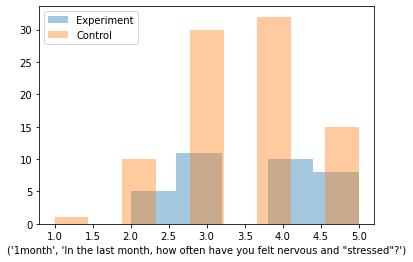

In the last month, how often have you found that you could not cope with all the things that you had to do?
Ttest_indResult(statistic=0.9343573040525952, pvalue=0.3519959738768932)



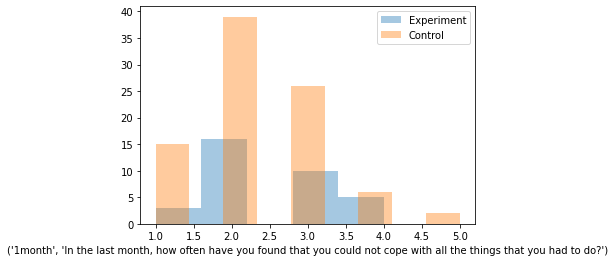

Feeling nervous, anxious or on edge
Ttest_indResult(statistic=-0.5152435834278873, pvalue=0.6073306808725583)



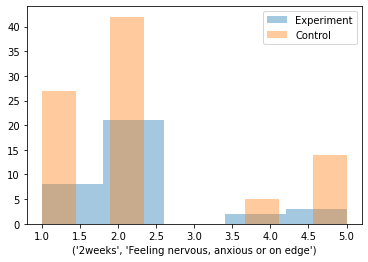

Not being able to stop or control worrying
Ttest_indResult(statistic=0.7774299650507879, pvalue=0.43843510443920264)



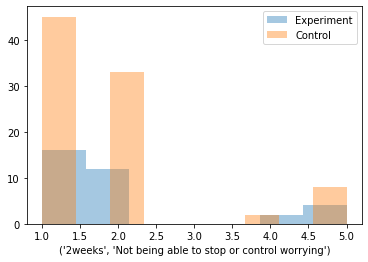

Worrying too much about different things
Ttest_indResult(statistic=0.5347405874643903, pvalue=0.5938186928053738)



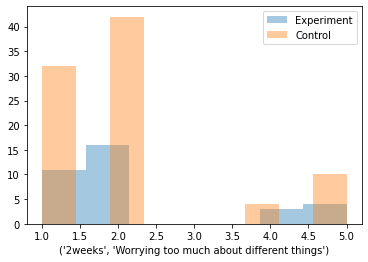

Trouble relaxing
Ttest_indResult(statistic=-0.24517863634963086, pvalue=0.8067369132553118)



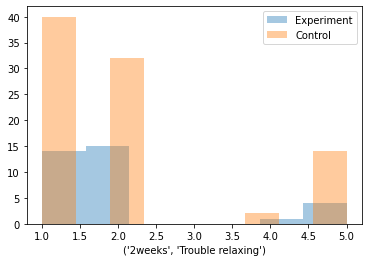

Being so restless that it is hard to sit still
Ttest_indResult(statistic=0.9922385765178534, pvalue=0.32307771848000766)



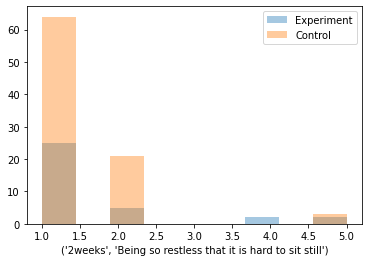

In [33]:
for k, v in enumerate(key_columns):
        
    print(v[1])
    print(ttest_ind(df_test.iloc[:,k].dropna(), df_control.iloc[:,k].dropna(), equal_var=True))
    print()        
            
    sns.distplot(df_test.iloc[:,k], kde=False, label='Experiment')
    sns.distplot(df_control.iloc[:,k], kde=False, label='Control')
    plt.legend()
    plt.show()

### Conclusions

From the t-test statistics and the histograms, there is no statically signifcant difference between the data sets and we fail to reject the null hypothesis. To better understand the question posed, we would need more responses for the experiment and control datasets.